 ## **Recommendation System: SVD-KNN-Count-Based-Approaches**



### Introduction

In this assignment, we embark on the journey of developing a recommendation system tailored for software product reviews. The core of our approach lies in harnessing the power of matrix factorization techniques, notably Singular Value Decomposition (SVD) and k-Nearest Neighbors (KNN), alongside a count-based methodology. These methodologies are pivotal in understanding and predicting user preferences, thereby enabling personalized software product recommendations. The SVD technique decomposes user-item interaction matrices to unearth latent features that capture underlying user preferences and item characteristics.

On the other hand, KNN leverages similarity metrics to find users or items that are most alike, facilitating recommendations based on these neighborhoods. Complementing these, our count-based approach provides a foundation for understanding popularity trends and general user consensus on products. Throughout this notebook, we detail the implementation, evaluation, and optimization of these algorithms, aiming to highlight their efficacy and potential in enhancing user experience through tailored recommendations. Through rigorous experimentation and validation, we aspire to demonstrate the strengths and limitations of each method, providing a comprehensive insight into the art and science of recommendation systems in the context of software product reviews.

### Importing Libraries

In [ ]:
!pip install scikit-surprise
!pip install datasketch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163004 sha256=0572d68f7e567ce30118f55e04ccbea5a0b5c1ef761c3a44e67b6a59b9b52cf8
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import re
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from surprise import Dataset, Reader, SVD, KNNWithMeans, accuracy
from surprise.model_selection import GridSearchCV, train_test_split as surprise_train_test_split, cross_validate
from datasketch import MinHash, MinHashLSH
from google.colab import drive
import requests
import io
import matplotlib.ticker as ticker
import pickle

### Dataset Description

The [dataset](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/#complete-data) utilized for this assignment consists of an extensive collection of software product reviews along with associated metadata collected from Amazon, covering a time span from 1998 to 2018. It is divided into two principal components: `software.pkl` and `meta_Software.json`, each providing unique insights into the reviews and the products respectively.

`software.pkl`

This part of the dataset encapsulates individual reviews, integrating both qualitative and quantitative data points. The dataset includes:

- `reviewerID`: A unique identifier for the reviewer.
- `asin`: The product's specific Amazon Standard Identification Number.
- `reviewerName`: The name of the reviewer.
- `vote`: The count of helpful votes a review has received.
- `style`: A dictionary capturing the product's metadata, such as format.
- `reviewText`: The textual content of the review.
- `overall`: The rating awarded by the reviewer.
- `summary`: A summary of the review.
- `unixReviewTime`: The timestamp of the review in UNIX format.






In [ ]:
df_software = pd.read_pickle('/content/drive/MyDrive/Recommender_Systems/Dataset/Software.pkl')
df_software.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,True,"03 11, 2014",A240ORQ2LF9LUI,0077613252,{'Format:': ' Loose Leaf'},Michelle W,The materials arrived early and were in excell...,Material Great,1394496000,NaN,NaN
1,4,True,"02 23, 2014",A1YCCU0YRLS0FE,0077613252,{'Format:': ' Loose Leaf'},Rosalind White Ames,I am really enjoying this book with the worksh...,Health,1393113600,NaN,NaN
2,1,True,"02 17, 2014",A1BJHRQDYVAY2J,0077613252,{'Format:': ' Loose Leaf'},Allan R. Baker,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",ARE YOU KIDING ME?,1392595200,7,NaN


`meta_Software.json`

This file is dedicated to the products themselves, detailing:

- `asin`: The product's Amazon Standard Identification Number.
- `title`: Name of the product.
- `feature`: Bullet-pointed features of the product.
- `description`: A narrative description of the product.
- `price`: The product's cost in US dollars at the time of data collection.
- `imageURL` and `imageURLHighRes`: URLs to the product's images.
- `related`: Information on related products (e.g., also bought, also viewed).
- `salesRank`: The product's sales rank.
- `brand`: The brand name.
- `categories`: The product's categories.
- `tech1` and `tech2`: Technical details of the product.
- `similar`: Listing of similar products.
- `reviewTime`: The review's time in raw format.
- `image`: User-posted product images post-purchase.


In [ ]:
df_meta = pd.read_json('/content/drive/MyDrive/Recommender_Systems/Dataset/meta_Software.json',lines=True)
df_meta.head(3)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,[],,[],,HOLT PHYSICS LESSON PRESENTATION CD-ROM QUICK ...,[],,HOLT. RINEHART AND WINSTON,[],"25,550 in Software (",[],Software,,</div>,.a-box-inner{background-color:#fff}#alohaBuyBo...,0030672120,[],[],NaN
1,[],,"[, <b>Latin rhythms that will get your kids si...",,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)...",[],,McGraw Hill,[],"15,792 in Software (",[],Software,,</div>,,0071480935,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,[],,[<b>Connect is the only integrated learning sy...,,Connect with LearnSmart Access Card for Microb...,[],,McGraw-Hill Science/Engineering/Math,[],"16,900 in Software (",[],Software,,</div>,,007329506X,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


### Initializing Essential Functions for Experimentation
In this section of the notebook, we initialize the essential class and functions that will be instrumental for our experimentation. This preparatory step ensures that all the necessary tools are at our disposal for conducting analyses, building models, and evaluating their performance.

In [ ]:
class LSHSimilarity:
    """
    A class for performing Locality Sensitive Hashing (LSH) based similarity search on a pandas DataFrame.

    Attributes:
        df (pd.DataFrame): The DataFrame containing the data for similarity search.
        focus_column (str): The primary column used to identify entities (e.g., 'reviewerID' or 'asin').
        secondary_column (str): The secondary column used for similarity comparison.
        ratings (dict): A dictionary storing the discretized ratings for each entity.
        index (MinHashLSH): The LSH index for fast similarity search.
        hashes (dict): A dictionary storing the MinHashes for each entity.
        threshold (float): The Jaccard similarity threshold for considering entities as neighbors.
    """

    def __init__(self, df: pd.DataFrame, focus_column: str):
        """
        Initializes the LSHSimilarity with a DataFrame and a focus column.

        Args:
            df (pd.DataFrame): The DataFrame to use for similarity search.
            focus_column (str): The primary column for identifying entities.
        """
        self.df = df
        self.focus_column = focus_column
        self.secondary_column = 'asin' if self.focus_column == 'reviewerID' else 'reviewerID'

    def discretize_rating(self, rating: float) -> str:
        """
        Converts a numeric rating into a discrete polarity category.

        Args:
            rating (float): The numeric rating to discretize.

        Returns:
            str: The discretized rating ('N' for negative, 'P' for positive, 'A' for average).
        """
        if rating < 3:
            return 'N'  # Negative
        elif rating > 3:
            return 'P'  # Positive
        else:
            return 'A'  # Average

    def load_ratings(self) -> dict:
        """
        Processes the DataFrame and loads ratings into a dictionary for fast access.

        Returns:
            dict: A dictionary mapping each entity to a set of (secondary_column, rating) tuples.
        """
        self.df.set_index(self.focus_column, inplace=True)
        distinct_ids = set(self.df.index.values)
        ratings = {}

        for id_ in tqdm(distinct_ids, desc='Ids processed'):
            id_ratings = self.df.loc[[id_], [self.secondary_column, 'overall']]
            ratings[id_] = set(zip(id_ratings[self.secondary_column], id_ratings['overall'].apply(self.discretize_rating)))

        return ratings

    def index(self, jaccard_threshold: float = 0.2, index_weights=(0.2, 0.8), num_of_permutations: int = 200, min_num: int = 5):
        """
        Creates an LSH index for the entities based on their ratings.

        Args:
            jaccard_threshold (float): The Jaccard similarity threshold for considering entities as neighbors.
            index_weights (tuple): The weights for the LSH index.
            num_of_permutations (int): The number of permutations to use for MinHash.
            min_num (int): The minimum number of ratings required to include an entity in the index.
        """
        index = MinHashLSH(threshold=jaccard_threshold, weights=index_weights, num_perm=num_of_permutations)
        print(f"Index built with {num_of_permutations} permutations")
        hashes = {}
        self.ratings = self.load_ratings()

        N = len(self.ratings)
        cnt = 0

        for eid, my_ratings in tqdm(self.ratings.items(), desc='Entities processed'):
            cnt += 1
            if cnt % 500 == 0:
                print(f"{cnt} out of {N} entities indexed.")

            if len(my_ratings) < min_num:
                continue

            rating_hash = MinHash(num_perm=num_of_permutations)
            for id_, pol in my_ratings:
                s = f"{id_}_{pol}"
                rating_hash.update(s.encode('utf8'))

            hashes[eid] = rating_hash
            index.insert(eid, rating_hash)

        print(f"{self.focus_column}-based index created")
        self.index, self.hashes, self.threshold = index, hashes, jaccard_threshold

    def jaccard(self, s1: set, s2: set) -> float:
        """
        Computes the Jaccard coefficient between two sets.

        Args:
            s1 (set): The first set.
            s2 (set): The second set.

        Returns:
            float: The Jaccard similarity coefficient.
        """
        return len(s1.intersection(s2)) / len(s1.union(s2))

    def get_neighbors(self, eid: int) -> list:
        """
        Retrieves the neighbors of a given entity based on the Jaccard similarity threshold.

        Args:
            eid (int): The entity ID for which to find neighbors.

        Returns:
            list: A list of tuples (neighbor_id, jaccard_similarity) for each neighbor.
        """
        result = self.index.query(self.hashes[eid])

        neighbors = []
        for nid in result:
            if nid == eid:
                continue

            jacc = self.jaccard(self.ratings[nid], self.ratings[eid])
            if jacc >= self.threshold:
                neighbors.append((nid, jacc))

        return neighbors

In [ ]:
def df_groupby_count(df: pd.DataFrame,
                     colname: str,
                     norm: bool = False) -> pd.DataFrame:
    """
    Groups a DataFrame by a specified column and counts the occurrences of each unique value.

    Parameters:
    - df: pd.DataFrame
        The DataFrame to be processed.
    - colname: str
        The name of the column to group the DataFrame by.
    - norm: bool, optional (default is False)
        If True, the count values are normalized to represent proportions rather than absolute counts.

    Returns:
    - pd.DataFrame
        A DataFrame with two columns: the specified column's unique values and their counts or proportions.

    Raises:
    - KeyError
        If the specified column name does not exist in the DataFrame.
    """
    if colname not in df.columns:
        raise KeyError(f"Column '{colname}' does not exist in the DataFrame.")

    try:
        temp_df = df[colname].value_counts(normalize=norm).reset_index()
        temp_df.columns = [colname, 'count']
        return temp_df
    except Exception as e:
        raise Exception(f"An error occurred while processing the DataFrame: {e}")



def print_dataset_summary(df: pd.DataFrame,
                          user_col: str,
                          product_col: str) -> None:
    """
    Prints a summary of the dataset including total number of ratings,
    unique users, and unique products.

    Parameters:
    - df: pd.DataFrame
        The DataFrame containing the dataset to summarize.
    - user_col: str
        The name of the column representing user IDs.
    - product_col: str
        The name of the column representing product IDs.

    Returns:
    - None


    Example:
    >>> print_dataset_summary(df=my_dataframe,
                      user_col='userid',
                      product_col='productid')
    """
    try:
        # Validate if specified columns exist in the DataFrame
        if user_col not in df.columns or product_col not in df.columns:
            missing_cols = [col for col in [user_col, product_col] if col not in df.columns]
            raise KeyError(f"Missing column(s) in DataFrame: {', '.join(missing_cols)}")

        # Calculating statistics
        total_ratings = df.shape[0]
        total_users = len(np.unique(df[user_col]))
        total_products = len(np.unique(df[product_col]))

        # Printing the summary
        print(f"\nTotal No of ratings : {total_ratings}")
        print(f"Total No of users   : {total_users}")
        print(f"Total No of products  : {total_products}")


        user_ratings_counts = df_groupby_count(df_software, user_col)
        prod_ratings_counts = df_groupby_count(df_software, product_col)

        print(f"Average number of ratings per user: {user_ratings_counts['count'].mean():.2f}")
        print(f"Average number of ratings per product: {prod_ratings_counts['count'].mean():.2f}")

    except Exception as e:
        print(f"An error occurred: {e}")


def plot_rating_distribution(df: pd.DataFrame,
                            rating_column: str,
                            color: str = "deepskyblue",
                            figsize: tuple = (10, 6)) -> None:
    """
    Plots the distribution of ratings from a DataFrame using a specified color for the bars.

    Parameters:
    - df : pd.DataFrame
        The DataFrame containing the rating data.
    - rating_column : str
        The name of the column in the DataFrame that contains the ratings to be plotted.
    - color : str, optional (default is "blue")
        The color to use for the plot. Can be any color name recognized by matplotlib/seaborn.
    - figsize : tuple, optional (default is (10, 6))
        The size of the figure (width, height) in inches.

    Returns:
    - None

    Example:
    >>> plot_rating_distribution(df=my-dataframe,
                         rating_column='overall',
                         color="#3e82fc")
    """
    try:
        # Validate if the rating column exists
        if rating_column not in df.columns:
            raise KeyError(f"Column '{rating_column}' does not exist in the DataFrame.")

        sns.set(style="ticks")
        fig, ax = plt.subplots(figsize=figsize)

        # Creating the count plot with the specified color
        countplot = sns.countplot(x=rating_column, data=df, color=color, ax=ax)
        ax.set_title('Distribution of Product Ratings', fontsize=15)
        ax.set_xlabel('Rating', fontsize=12)
        ax.set_ylabel('Count', fontsize=12)

        # Annotating each bar with its count
        for p in countplot.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

        sns.despine()
        plt.show()
    except Exception as e:
        print(f"An error occurred: {e}")


def aggregate_dataframe_by_column(df: pd.DataFrame,
                                  groupby_column: str,
                                  aggregations: Dict[str, Any]) -> pd.DataFrame:
    """
    Aggregates a DataFrame by a specified column and applies given aggregation functions to other columns.

    Parameters:
    - df : pd.DataFrame
        The DataFrame to be aggregated.
    - groupby_column : str
        The column name to group the DataFrame by.
    - aggregations : Dict[str, Any], optional
        A dictionary specifying the columns to aggregate and the functions to apply to them.

    Returns:
    - pd.DataFrame
        A DataFrame with the grouping column, and each specified aggregation as a column.

    Example:
    >>> aggregate_dataframe_by_column(df=my_dataframe, groupby_column='category',
                                      aggregations={'price': 'mean', 'rating': 'max'})
    """
    try:
        # Perform the groupby and aggregation
        df_grouped = df.groupby(groupby_column).agg(aggregations).reset_index()

        # Rename columns to reflect the aggregation operations
        new_column_names = [groupby_column] + [f'{col}_{op}' for col, op in aggregations.items()]
        df_grouped.columns = new_column_names

        return df_grouped
    except KeyError as e:
        raise KeyError(f"Column not found in DataFrame: {e}")
    except Exception as e:
        raise Exception(f"An error occurred during aggregation: {e}")


def plot_rating_over_time(df: pd.DataFrame,
                          time_column: str,
                          avg_rating_col: str,
                          count_col: str,
                          figsize: tuple = (12, 8),
                          color: str = 'deepskyblue') -> None:
    """
    Plots the average rating over time and the number of ratings over time from a DataFrame.

    Parameters:
    - df : pd.DataFrame
        The DataFrame containing the data to plot.
    - time_column : str
        The column name that represents time or a temporal aspect to group data by.
    - avg_rating_col : str
        The column name in the DataFrame that contains average rating values.
    - count_col : str
        The column name in the DataFrame that contains count of ratings or products.
    - figsize : tuple, optional (default is (12, 8))
        The size of the figure (width, height) in inches.
    - color : str, optional (default is 'deepskyblue')
        The color to use for both plots.

    Returns:
    - None

    Example:
    >>> plot_rating_over_time(df=my_dataframe,
                      time_column="year",
                      avg_rating_column="rating_mean_per_year",
                      count_col="product_count")
    """

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

    # Plotting average rating over time
    sns.lineplot(x=time_column, y=avg_rating_col, data=df, color=color, ax=ax1)
    ax1.set_title(f'Average Rating by {time_column.capitalize()}')
    ax1.set_ylim([0, 5])
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Plotting count of ratings over time
    sns.barplot(x=time_column, y=count_col, data=df, color=color, ax=ax2)
    ax2.set_title(f'Number of Ratings by {time_column.capitalize()}')

    # Set x-tick labels to ensure all years are shown
    all_years = df[time_column].unique()
    ax2.set_xticks(range(len(all_years)))
    ax2.set_xticklabels(all_years, rotation=90)

    plt.tight_layout()
    plt.show()


def plot_popular_product_or_user(df: pd.DataFrame,
                          id_col: str,
                          count_col: str,
                          rating_col: str,
                          top_n:int = 5,
                          is_product: bool = 1) -> list:
    """
    Plots the average rating and the number of ratings of the top N most popular products/users.

    Parameters:
    - df: DataFrame containing product data.
    - product_id_col: The column name for the product/user identifier.
    - count_col: The column name for the count of ratings/reviews.
    - rating_col: The column name for the average rating.
    - top_n: Number of top products/users to plot (default is 5).
    - is_product: Takes 1 if we want to plot products and 0 for users.'

    Return:
    - A list with top k products/users ids

    Example
    >>> top_k_users = plot_popular_product_or_user(df=df_users,
                      id_col='reviewerID',
                      count_col='count',
                      rating_col='overall_mean',
                      top_n=20,
                      is_product=0)
    """

    # Ensure correct data types
    df[count_col] = df[count_col].astype(int)
    df[rating_col] = df[rating_col].astype(float)

    top_items= df.sort_values(by=count_col, ascending=False).head(top_n)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot number of ratings
    color = '#3e82fc'
    ax1.set_xlabel('Product', fontsize=14)
    ax1.set_ylabel('Number of Ratings', color=color, fontsize=14)
    bars = ax1.bar(top_items[id_col], top_items[count_col], color=color, alpha=0.6)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=90)

    if is_product == 0:
      ax1.set_xlabel('User', fontsize=14)
      ax1.set_ylabel('Number of Ratings', color=color, fontsize=14)
      bars = ax1.bar(top_items[id_col], top_items[count_col], color=color, alpha=0.6)
      ax1.tick_params(axis='y', labelcolor=color)
      ax1.tick_params(axis='x', rotation=90)

    # Instantiate a second axes that shares the same x-axis for the average rating
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Average Rating', color=color, fontsize=14)
    ax2.plot(top_items[id_col], top_items[rating_col], color=color, marker='o', linestyle='None')
    ax2.tick_params(axis='y', labelcolor=color)



    # Title and layout adjustments for clarity and aesthetics
    plt.title('Top {} Most Popular Products: Ratings & Counts'.format(top_n), fontsize=16)
    if is_product == 0:
          plt.title('Top {} Most Popular Users: Ratings & Counts'.format(top_n), fontsize=16)

    fig.tight_layout()

    # Show plot
    plt.show()

    return  list(top_items[id_col])



def print_product_descriptions(df: pd.DataFrame,
                              product_id_list: list,
                              product_id_col: str,
                              description_col: str) -> None:
    """
    Prints the corresponding descriptions for a given list of products from the DataFrame.

    Parameters:
    - df: DataFrame containing product data.
    - product_id_list: List of product ids to lookup descriptions.
    - product_id_col: The column name for the product ids.
    - description_col: The column name for the description.
    """

    for product_id in product_id_list:
        matching_row = df[df[product_id_col] == product_id]


        if not matching_row.empty:
            for desc in matching_row[description_col]:
                print(f"Product Id: {product_id}\nDescription: {desc}\n")
        else:
            print(f"Product Id: {product_id} not found in the dataset.\n")


def filter_dataframe(df: pd.DataFrame,
                     user_col: str,
                     prod_col: str,
                     rating_col: str,
                     product_threshold: int,
                     user_threshold: int) -> pd.DataFrame:
    """
    Filter the DataFrame to keep only users who have written (user_threshold) or more reviews and products that have at least (product_threshold) ratigns.

    Parameters:
    - df: pandas.DataFrame, the input DataFrame.
    - user_col: str, the name of the column containing user IDs.
    - prod_col: str, the name of the column containing product IDs.
    - rating_col: str, the name of the column containing rating values.
    - product_threshold: int, the minimum number of ratings required for products.
    - user_threshold: int, the minimum number of ratings that a user have done.

    Returns:
    - pd.DataFrame, the filtered DataFrame.
    """

    # Keep only products with at least 'threshold' ratings
    prod_counts = df.groupby(prod_col)[rating_col].count()
    products_with_enough_reviews = prod_counts[prod_counts >= product_threshold].index
    filtered_df = df[df[prod_col].isin(products_with_enough_reviews)]

    # Keep only users with at least 'user_threshold' reviews/ratings within the already filtered product set
    user_counts = filtered_df.groupby(user_col)[rating_col].count()
    users_with_enough_reviews = user_counts[user_counts >= user_threshold].index
    final_filtered_df = filtered_df[filtered_df[user_col].isin(users_with_enough_reviews)]

    return final_filtered_df


def split_dataframe(df: pd.DataFrame,
                    target_column: str,
                    train_size: float = 0.7,
                    random_state: int = None) -> (pd.DataFrame, pd.DataFrame):

    """
    Splits a DataFrame into train and test datasets, stratifying by the specified column.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be split.
    - target_column (str): The name of the column to stratify by. This column will be included in the output.
    - train_size (float): The proportion of the dataset to include in the train split.
    - random_state (int, optional): Controls the shuffling applied to the data before applying the split.

    Returns:
    - train_data (pd.DataFrame): The training dataset.
    - test_data (pd.DataFrame): The test dataset.
    """

    # Validate if target_column exists in df
    if target_column not in df.columns:
        raise ValueError(f"Column '{target_column}' not found in DataFrame.")

    # Splitting the dataframe, ensuring to stratify based on the target_column
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size,
                                                        random_state=random_state, stratify=y)

    # Reattach the target_column to the train and test datasets
    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)

    return train_data, test_data



def train_svd(df: pd.DataFrame,
        k_singular_values: int,
        param_grid: dict = None) -> (SVD, list, SVD):
    """
    Performs Singular Value Decomposition (SVD) on the provided DataFrame to facilitate recommendation
    systems or dimensionality reduction tasks. This function incorporates a train-test split for model
    evaluation and utilizes cross-validation for hyperparameter tuning of the SVD model.

    Parameters:
    - df (pd.DataFrame): A pandas DataFrame containing at least 'reviewerID', 'asin', and 'overall' columns.
                         These represent the user ID, item ID, and rating respectively.
    - k_singular_values (int): The number of singular values to retain. This parameter directly influences
                               the 'n_factors' attribute of the Surprise SVD model, determining the dimensionality
                               of the feature space.
    - param_grid (dict, optional): A dictionary specifying the hyperparameters for grid search optimization.
                                   If not provided, a default set of parameters is used.

    Returns:
    - initial_svd (SVD): The initially trained SVD model before hyperparameter tuning, trained with the specified
                         number of singular values.
    - predictions (list): A list of prediction results from testing the initial model on the test dataset.
    - best_svd (SVD): The optimized SVD model after hyperparameter tuning, trained on the entire dataset.

    Note:
    The function prints the dataset sparsity, initial model performance (RMSE), results from the hyperparameter
    tuning process, and the performance of the optimized model.
    """
    print("Starting the SVD process...")

    # Calculate and display dataset sparsity
    n_users = df['reviewerID'].nunique()
    n_items = df['asin'].nunique()
    sparsity = 1.0 - len(df) / (n_users * n_items)
    print(f"Dataset Sparsity: The dataset consists of {n_users} users and {n_items} items, resulting in a sparsity of {sparsity:.4f}.")

    # Set default parameters if none are provided
    if param_grid is None:
        param_grid = {
            'n_factors': [50, 100, 150, 200],
            'n_epochs': [20, 30],
            'lr_all': [0.005, 0.01],
            'reg_all': [0.02, 0.1]
        }

    # Prepare the dataset for Surprise
    print("Preparing the dataset for model training and evaluation...")
    reader = Reader(rating_scale=(df['overall'].min(), df['overall'].max()))
    data = Dataset.load_from_df(df[['reviewerID', 'asin', 'overall']], reader)

    # Split dataset into training and testing sets
    print("Splitting the dataset into training and testing sets...")
    train_set, test_set = surprise_train_test_split(data, test_size=0.25, random_state=42)

    # Train the initial SVD model
    print(f"Training the initial SVD model with n_factors set to {k_singular_values}...")
    initial_svd = SVD(n_factors=k_singular_values)
    initial_svd.fit(train_set)
    predictions = initial_svd.test(test_set)

    # Evaluate initial model performance
    print("Evaluating the initial model's performance on the test set...")
    rmse = accuracy.rmse(predictions)
    print(f"Initial Model RMSE: {rmse:.4f}")

    # Perform hyperparameter tuning with GridSearchCV
    print("Initiating hyperparameter tuning with GridSearchCV...")
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(data)

    # Display detailed cross-validation results
    print("Cross-Validation Results:")
    for i in range(len(gs.cv_results['mean_test_rmse'])):
        print(f"Fold {i+1}: Mean RMSE = {gs.cv_results['mean_test_rmse'][i]}, Mean MAE = {gs.cv_results['mean_test_mae'][i]}")

    # Determine the best SVD model from tuning
    best_svd = gs.best_estimator['rmse']
    print(f"Optimal Parameters: {gs.best_params['rmse']}")
    print(f"Best RMSE from Tuning: {gs.best_score['rmse']:.4f}")

    # Retrain the best model on the full dataset
    print("Retraining the best model on the full dataset...")
    train_set_full = data.build_full_trainset()
    best_svd.fit(train_set_full)


    print("SVD process completed.")

    return initial_svd, predictions, best_svd


def recommend_svd(uid: str,
                       df: pd.DataFrame,
                       rec_num: int,
                       svdtuned,
                       df_meta: pd.DataFrame) -> pd.DataFrame:
    """
    Generates personalized product recommendations for a specified user.

    This function utilizes a pre-tuned SVD (Singular Value Decomposition) model to predict ratings for products
    that the user has not yet rated. It then returns a specified number of products with the highest predicted
    ratings.

    Parameters:
    - uid (str): The ID of the user for whom recommendations are to be made.
    - df (pd.DataFrame): The DataFrame containing the reviews data.
    - rec_num (int): The number of recommendations to return.
    - svdtuned: The trained and tuned SVD model to use for predictions.
    - df_meta: The metadata if the products.

    Returns:
    - rec_df (pd.DataFrame): A DataFrame containing the recommended products, sorted by predicted rating.
    """


    # Calculate ratings_matrix
    train_data, test_data = split_dataframe(df=df_processed,target_column='reviewerID',train_size=0.7,random_state=42)

    ratings_matrix = train_data.pivot_table(index = 'reviewerID', columns ='asin', values = 'overall', aggfunc='mean').fillna(df.overall.mean())


    # Get all the ratings by this user
    my_ratings = df[df.reviewerID == uid]

    # Zip the ratings into a dict
    already_rated = dict(zip(my_ratings.asin, my_ratings.overall))

    # Locate user in ratings_matrix
    df_index = ratings_matrix.index.get_loc(uid)

    #predict the rating of this user for all products
    predicted_ratings = {iid: svdtuned.predict(uid=uid, iid=iid).est for iid in df.asin.unique()}
    pred_dict = dict(sorted(predicted_ratings.items(), key=lambda item: item[1],reverse=True))
    rec_set = set()

    for mid in pred_dict.keys():
        if mid not in already_rated:
            rec_set.add(mid)
            if len(rec_set) == rec_num: break

    rec_df = pd.DataFrame(df_meta[df_meta.asin.isin(rec_set)])
    rec_df['predicted_rating'] = rec_df['asin'].map(pred_dict)

    rec_df = rec_df.sort_values(['predicted_rating'], ascending=False)
    rec_df = rec_df[['asin', 'title', 'predicted_rating']]
    rec_df.drop_duplicates(inplace=True)
    return rec_df


def validate_svd(uid: str,
                 df: pd.core.frame.DataFrame,
                 svdtuned,
                 df_meta: pd.DataFrame) -> Tuple[float, pd.core.frame.DataFrame]:
    """
    Validates the Singular Value Decomposition (SVD) model's performance by comparing predicted ratings
    against actual ratings for a given user. This function splits the data into training and testing sets,
    predicts ratings for the test set, and calculates the root mean squared error (RMSE) of these predictions.
    It also returns a DataFrame of the products rated by the user, with actual and predicted ratings.

    Parameters:
    - uid (str): User ID for whom the validation is performed.
    - df (pd.core.frame.DataFrame): DataFrame containing the dataset to be used for training and testing.
    - svdtuned: The trained SVD model used for making predictions.

    Returns:
    Tuple[float, pd.core.frame.DataFrame]: A tuple containing the RMSE of the predictions and a DataFrame with
    the actual and predicted ratings for products rated by the specified user.
    """

    if not df['reviewerID'].str.contains(uid).any():
        raise ValueError(f"User ID {uid} does not exist in the dataset.")

    # Assuming split_dataframe is defined elsewhere
    train_data, test_data = split_dataframe(df=df, target_column='reviewerID', train_size=0.7, random_state=42)

    # Predict ratings for the test set
    predicted_ratings = {iid: round(svdtuned.predict(uid, iid).est, 2) for iid in df['asin'].unique()}

    # Extract actual ratings from the test data
    actual_ratings = test_data[test_data['reviewerID'] == uid][['asin', 'overall']]

    # Merge actual and predicted ratings for comparison
    actual_ratings['predicted'] = actual_ratings['asin'].apply(lambda x: predicted_ratings.get(x, 0))

    # Calculate RMSE
    rmse_score = mean_squared_error(actual_ratings['overall'], actual_ratings['predicted'], squared=False)

    # Prepare the recommendations DataFrame
    rec_df = pd.merge(actual_ratings, df_meta[['asin', 'title']], on='asin')
    rec_df.rename(columns={'overall': 'actual_rating', 'predicted': 'predicted_rating'}, inplace=True)

    return rmse_score, rec_df.sort_values(by='predicted_rating', ascending=False)


def save_to_file(obj, filename):
    """
    Saves a given object to a file using pickle.

    Parameters:
    - obj: The Python object to save (e.g., a machine learning model or a data structure).
    - filename: The path to the file where the object should be saved.
    """
    try:
        with open(filename, 'wb') as file:
            pickle.dump(obj, file)
        print(f'Object saved to {filename}')
    except Exception as e:
        print(f'Failed to save object to {filename}. Error: {e}')



def load_from_file(filename):
    """
    Loads a Python object from a file using pickle.

    Parameters:
    - filename: The path to the file from which the object should be loaded.

    Returns:
    - The Python object loaded from the file.
    """
    try:
        with open(filename, 'rb') as file:
            obj = pickle.load(file)
        print(f'Object loaded from {filename}')
        return obj
    except Exception as e:
        print(f'Failed to load object from {filename}. Error: {e}')
        return None



def train_knn(df: pd.DataFrame,
              param_grid: dict = None) -> (KNNWithMeans, list, KNNWithMeans, list):
    """
    Trains a KNN-based model using the provided DataFrame to facilitate recommendation systems.
    This function includes a train-test split for model evaluation and employs cross-validation
    for hyperparameter tuning of the KNN model. Additionally, it utilizes an anti-test set for evaluating the model's
    ability to predict unseen ratings. The anti-test set comprises user-item pairs from the dataset
    for which no ratings have been provided, allowing the evaluation of the model's performance on unseen data.

    Parameters:
    - df (pd.DataFrame): A pandas DataFrame containing at least 'reviewerID', 'asin', and 'overall' columns.
                         These represent the user ID, item ID, and rating respectively.
    - param_grid (dict, optional): A dictionary specifying the hyperparameters for grid search optimization.
                                   If not provided, a default set of parameters is used.

    Returns:
    - initial_knn (KNNWithMeans): The initially trained KNN model before hyperparameter tuning, trained with default parameters.
    - test_predictions (list): A list of prediction results from testing the initial model on the test dataset.
    - best_knn (KNNWithMeans): The optimized KNN model after hyperparameter tuning, trained on the entire dataset.
    - anti_test_predictions (list): A list of prediction results from testing the optimized model on the anti-test dataset.
    """
    print("Starting the KNN process...")

    # Prepare the dataset for Surprise
    print("Preparing the dataset for model training and evaluation...")
    reader = Reader(rating_scale=(df['overall'].min(), df['overall'].max()))
    data = Dataset.load_from_df(df[['reviewerID', 'asin', 'overall']], reader)

    # Default sim_options if not provided
    sim_options = {
        "name": "msd",
        "user_based": True,
    }

    # Set default parameters if none are provided
    if param_grid is None:
        param_grid = {
            'k': [10, 20, 40, 100],
            'sim_options': {
                'name': ['msd', 'cosine', 'pearson'],
                'min_support': [1, 5, 10],
                'user_based': [True, False]
            }
        }

    # Split dataset into training and testing sets
    print("Splitting the dataset into training and testing sets...")
    train_set, test_set = surprise_train_test_split(data, test_size=0.25, random_state=42)

    # Train the initial KNN model
    print("Training the initial KNN model with default parameters...")
    initial_knn = KNNWithMeans(sim_options=sim_options)
    initial_knn.fit(train_set)
    test_predictions = initial_knn.test(test_set)

    # Evaluate initial model performance
    print("Evaluating the initial model's performance on the test set...")
    rmse = accuracy.rmse(test_predictions)
    print(f"Initial Model RMSE: {rmse:.4f}")

    # Perform hyperparameter tuning with GridSearchCV
    print("Initiating hyperparameter tuning with GridSearchCV...")
    gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=5)
    gs.fit(data)

    # Display detailed cross-validation results
    print("Cross-Validation Results:")
    print(f"Best RMSE from Tuning: {gs.best_score['rmse']:.4f}")
    print(f"Optimal Parameters: {gs.best_params['rmse']}")

    # Determine the best KNN model from tuning
    best_knn = gs.best_estimator['rmse']

    # Retrain the best model on the full dataset
    print("Retraining the best model on the full dataset...")
    trainingSet = data.build_full_trainset()
    best_knn.fit(trainingSet)

    # Create and predict on the anti-test set
    print("Predicting on the anti-test set...")
    anti_set = trainingSet.build_anti_testset()
    anti_test_predictions = best_knn.test(anti_set)

    print("KNN process completed.")

    return initial_knn, test_predictions, best_knn, anti_test_predictions


def recommend_knn(uid: str,
                  ratings_df: pd.DataFrame,
                  pred_df: pd.DataFrame,
                  df_meta: pd.DataFrame,
                  rec_num: int = 20) -> pd.DataFrame:
    """
    Recommends items to a user based on KNN predictions.

    This function identifies items that a user has not yet rated and recommends a number of items
    based on the highest estimated ratings predicted by a KNN model.

    Parameters:
    - uid (str): The unique identifier of the user for whom recommendations are being made.
    - ratings_df (pd.DataFrame): A DataFrame containing user ratings. Must include columns 'reviewerID', 'asin', and 'overall'.
    - pred_df (pd.DataFrame): A DataFrame containing the KNN predictions. Must include columns 'uid', 'iid', and 'est' for user ID, item ID, and estimated rating, respectively.
    - df_meta (pd.DataFrame): A DataFrame containing metadata for the items, including at least 'asin' and 'title'.
    - rec_num (int, optional): The number of recommendations to return. Defaults to 20.
    - df_meta: The metadata of the products.

    Returns:
    pd.DataFrame: A DataFrame containing the top recommended items for the user, including item ID ('iid'), estimated rating ('est'), and item title ('title').
    """

    # Extract the user's ratings from the ratings DataFrame
    user_ratings = ratings_df[ratings_df.reviewerID == uid]

    # Create a dictionary of items the user has already rated
    already_rated = dict(zip(user_ratings.asin, user_ratings.overall))

    # Filter and sort the predictions DataFrame for the user, based on estimated rating
    sorted_predictions = pred_df[pred_df['uid'] == uid].sort_values(by='est', ascending=False)

    # Initialize a set to store recommended item IDs
    rec_set = set()

    # Iterate through sorted predictions to find items not already rated by the user
    for _, row in sorted_predictions.iterrows():
        if row['iid'] not in already_rated and len(rec_set) < rec_num:
            rec_set.add(row['iid'])

    # Filter the predictions DataFrame for the recommended items and the specific user
    filtered_pred_df = pred_df[(pred_df['iid'].isin(rec_set)) & (pred_df['uid'] == uid)]

    # Merge with item metadata DataFrame to get titles
    recommendations = filtered_pred_df.merge(df_meta, left_on='iid', right_on='asin')

    # Return the top recommendations sorted by estimated rating
    return recommendations[['iid', 'est', 'title']].sort_values(by='est', ascending=False)


def validate_knn(uid: str,
                 ratings_df: pd.DataFrame,
                 pred_df: pd.DataFrame,
                 model) -> float:
    """
    Validates the KNN algorithm predictions against actual user ratings.

    This function computes the Root Mean Squared Error (RMSE) between the actual ratings
    given by a user and the ratings predicted by the KNN algorithm, for items the user has rated.

    Parameters:
    - uid (str): The unique identifier of the user whose ratings are to be validated.
    - ratings_df (pd.DataFrame): A DataFrame containing user ratings, with columns 'reviewerID', 'asin', and 'overall'.
    - pred_df (pd.DataFrame): A DataFrame containing the KNN predictions. This parameter is currently not used in the function but included for future enhancements.
    - model: The prediction algorithm object that has a predict method which accepts user ID and item ID as inputs and returns a prediction.

    Returns:
    float: The RMSE between the actual ratings and the predicted ratings.
    """

    # Extract the user's ratings from the ratings DataFrame
    user_ratings = ratings_df[ratings_df.reviewerID == uid]
    # Create a dictionary of items the user has rated and their ratings
    already_rated = dict(zip(user_ratings.asin, user_ratings.overall))

    # Initialize lists to store actual and predicted ratings
    actual_ratings, predicted_ratings = [], []

    # Iterate over items the user has rated
    for item_id in already_rated:
        # Append the actual rating to the list
        actual_ratings.append(already_rated[item_id])
        # Use the prediction algorithm to predict the rating and append it to the list
        predicted_ratings.append(model.predict(uid, item_id)[3])

    # Print actual and predicted ratings for debugging/inspection
    print(actual_ratings, predicted_ratings)

    # Compute and return the RMSE between actual and predicted ratings
    return mean_squared_error(actual_ratings, predicted_ratings, squared=False)





def recommend_item_based(indexer: LSHSimilarity,
                         user_id: str, rec_num: int,
                         verbose: bool = True,
                         for_validation: bool = False):
    """
    Generates item-based recommendations for a given user by leveraging the LSH index.

    Args:
        indexer (LSHSimilarity): The LSH similarity searcher instance.
        user_id (str): The ID of the user for whom recommendations are to be generated.
        rec_num (int): The number of recommendations to generate.
        verbose (bool, optional): If True, additional logs are printed. Defaults to True.
        for_validation (bool, optional): If True, excludes already rated items from recommendations. Defaults to False.

    Returns:
        tuple: A tuple containing two DataFrames - the recommendations and the already rated items by the user.
    """
    # Fetch neighbors based on the provided user ID
    neighbors = indexer.get_neighbors(user_id)

    # Initialize a dictionary to count votes for each product
    votes = defaultdict(int)

    for neighbor, sim_val in neighbors:
        # Iterate over each product rated by the neighbor
        for mid, pol in indexer.ratings[neighbor]:
            # Adjust votes based on rating polarity and similarity value
            if pol == 'P':  # Positive neighbor rating
                votes[mid] += 2 * sim_val
            elif pol == 'N':  # Negative rating
                votes[mid] -= 2 * sim_val
            else:  # Average rating
                votes[mid] -= sim_val

    # Sort products based on their accumulated votes, in descending order
    sorted_votes = sorted(votes.items(), key=lambda x: x[1], reverse=True)

    # Track already rated items to exclude them from recommendations if needed
    already_rated = {}
    previous_ratings = {x: y for x, y in indexer.ratings[user_id]}
    recommendations = []

    for product_id, score in sorted_votes:
        # Attempt to fetch the product title; use placeholder if not found
        try:
            title = df_meta[df_meta['asin'] == product_id]['title'].iloc[0]
        except KeyError:
            title = 'placeholder'

        # Check if the product was already rated by the user
        rating = previous_ratings.get(product_id, None)
        if rating and not for_validation:
            already_rated[title] = rating
            continue
        # Add to recommendations
        recommendations.append({"asin": product_id, 'title': title, 'score': score})

        if len(recommendations) == rec_num:
            break

    # Convert recommendations and already rated items into DataFrames for easier handling
    df_recommendations = pd.DataFrame(recommendations)
    df_already_rated = pd.DataFrame([already_rated])

    return df_recommendations, df_already_rated



def calculate_novelty(user_items: set,
                      recommended_items: set) -> float:
    """
    Calculates the novelty of the recommended items compared to the items the user has already interacted with.

    Novelty is defined here as 1 minus the Jaccard similarity between the set of items a user has interacted with
    and the set of recommended items. This measures how different the recommended items are from the user's past interactions.

    Args:
        user_items (set): A set of items the user has interacted with.
        recommended_items (set): A set of items recommended to the user.

    Returns:
        float: The novelty score, where higher values indicate more novel recommendations.
    """
    interacted_items = set(user_items)
    recommended_items_set = set(recommended_items)

    intersection_size = len(interacted_items.intersection(recommended_items_set))
    union_size = len(interacted_items.union(recommended_items_set))

    jaccard_similarity = intersection_size / union_size if union_size > 0 else 0
    novelty_score = 1 - jaccard_similarity

    return novelty_score


def calculate_ndcg(relevance_scores: list,
                   k: int) -> float:
    """
    Calculates the Normalized Discounted Cumulative Gain (NDCG) at a specific rank position (k).

    NDCG is a measure of ranking quality, taking into account the position of relevant items within the recommendation list.
    Higher scores are better, with 1 being the perfect score. The function assumes the highest relevance scores indicate
    the most relevant items.

    Args:
        relevance_scores (list): A list or numpy array of relevance scores, with higher scores indicating higher relevance.
        k (int): The rank position up to which the NDCG is calculated.

    Returns:
        float: The NDCG score for the given relevance scores up to position k.
    """
    relevance_scores = np.asarray(relevance_scores)
    sorted_scores = np.sort(relevance_scores)[::-1]

    ideal_dcg = np.sum((2**sorted_scores - 1) / np.log2(np.arange(2, len(sorted_scores) + 2)))
    dcg = np.sum((2**relevance_scores[:k] - 1) / np.log2(np.arange(2, k + 2)))

    return dcg / ideal_dcg if ideal_dcg > 0 else 0


def validate_item_based_recommendations(data,
                                        user_id: str,
                                        indexer) -> tuple:
    """
    Validates the item-based recommendation system for a specific user by calculating novelty and NDCG scores.

    This function generates recommendations for a given user, then calculates the novelty of these recommendations
    compared to the items the user has already interacted with. It also calculates the Normalized Discounted Cumulative Gain (NDCG)
    score to assess the quality of the ranking of recommended items.

    Args:
        data (list or set): A list or set of items the user has interacted with.
        user_id (str): The ID of the user for whom recommendations are to be validated.
        indexer (LSHSimilaritySearcher): The LSH similarity searcher instance used for generating recommendations.

    Returns:
        tuple: A tuple containing the novelty score and the NDCG score for the recommendations.
    """
    user_items = data
    # Generate recommendations for validation
    recommended_items, _ = recommend_item_based(indexer, user_id=user_id, rec_num=20, for_validation=True)

    if recommended_items.empty:
        return 0, 0

    # Calculate novelty score based on the user's interactions and the recommended items
    novelty_score = calculate_novelty(user_items, recommended_items['asin'].unique())

    # Calculate NDCG score based on the relevance scores of the recommended items
    ndcg_score = calculate_ndcg(list(recommended_items['score']), 10)

    return novelty_score, ndcg_score

### Unveiling Data Insights: A Deep Dive into Exploratory Analysis

In the following section, we embark on an exploratory analysis journey, where we dive deep into our dataset to uncover patterns, trends, and anomalies. This crucial phase enables us to gain a comprehensive understanding of the underlying structure of our data, guiding our subsequent modeling decisions. Through visualizations, statistical summaries, and initial observations, we aim to establish a solid groundwork for hypothesis formation and predictive modeling. This exploratory analysis not only illuminates the characteristics of the dataset but also helps in identifying potential challenges and opportunities for our experimentation process.

The **print_dataset_summary** function is a function designed to provide a snapshot of a given dataset's dimensions, specifically within the context of user-item interaction data. When applied to the **df_software** DataFrame, which presumably holds data related to software reviews, the function reveals several key metrics: there are a total of **459,436 ratings** provided by **37,5147 unique users** across **21,663 unique products**.

In [ ]:
print_dataset_summary(df=df_software,
                      user_col='reviewerID',
                      product_col='asin')


Total No of ratings : 459436
Total No of users   : 375147
Total No of products  : 21663
Average number of ratings per user: 1.22
Average number of ratings per product: 21.21


The function further enriches our understanding by calculating the average number of ratings per user, which stands at 1.22, indicating that on average, users tend to rate just over one product. Conversely, the average number of ratings per product is 21.21, suggesting that products typically receive ratings from multiple users, hinting at a reasonably broad engagement across the product range in the dataset.

The **plot_rating_distribution** function is a visualization tool that generates a bar chart representing the distribution of product ratings in a given dataset. When applied to the df_software DataFrame, it offers a visual representation of how many times each rating (from 1 to 5) has been given by users.

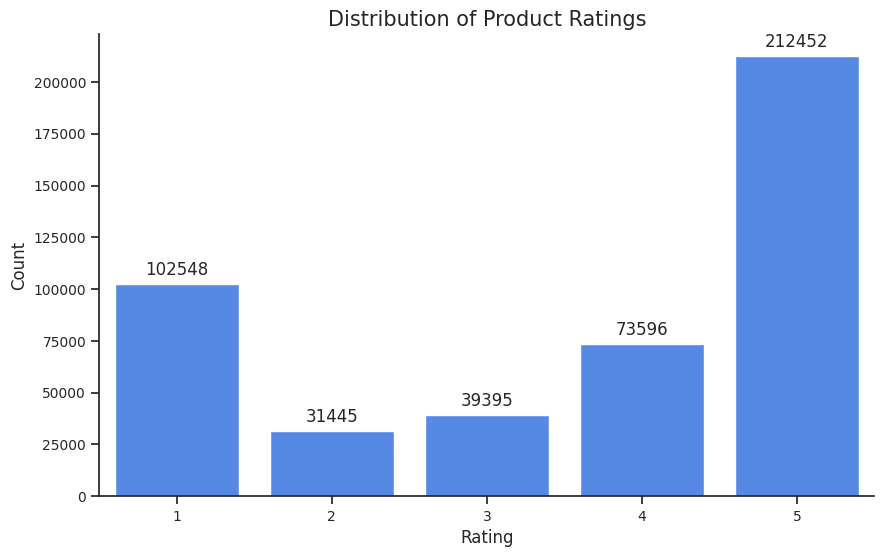

In [ ]:
plot_rating_distribution(df=df_software,
                         rating_column='overall',
                         color="#3e82fc")

The output is a clear, well-annotated bar chart that highlights the frequency of each rating. As we can see, the rating '5' is the most frequent, with over 200,000 counts, indicating a potential skew towards higher ratings within this dataset. This could suggest a level of satisfaction among the users or a tendency to rate only when satisfied. On the other hand, the lower ratings (1 and 2) are less frequent but still significant, with '1' occurring over 100,000 times.


The **plot_rating_over_time** function is designed to visually communicate the evolution of user engagement and sentiment over time within a dataset. By plotting two graphs, one for the average rating per time period and another for the count of ratings per time period, it provides a dual perspective on both the quantity and quality of user feedback.

In [ ]:
df_software['year'] = df_software['reviewTime'].str.split(', ').str[1].astype(int)
df_software['month'] = df_software['reviewTime'].str[:2].astype(int)

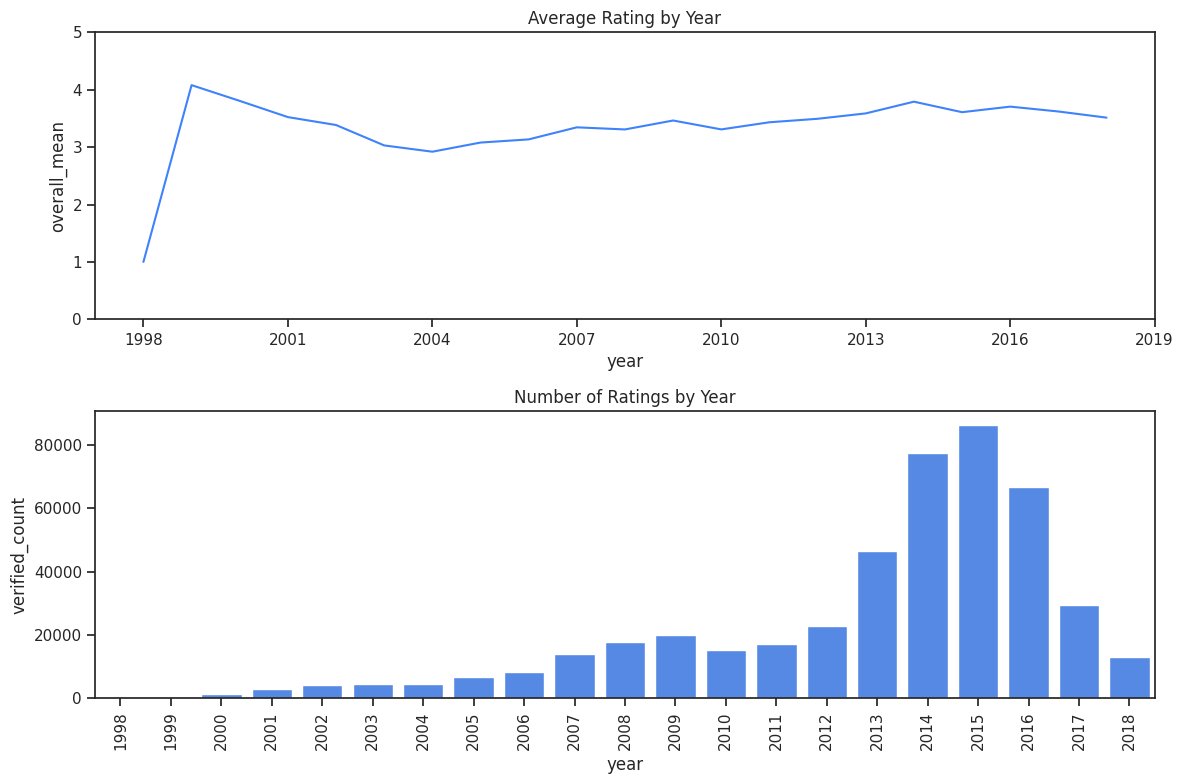

In [ ]:
year_df = aggregate_dataframe_by_column(df=df_software,
                              groupby_column='year',
                              aggregations={'verified': 'count', 'overall': 'mean'})

plot_rating_over_time(df=year_df,
                      time_column="year",
                      avg_rating_col="overall_mean",
                      count_col="verified_count",
                      color="#3e82fc")

In the application to the year_df DataFrame, this function reveals two trends: the average rating remains relatively stable over time, fluctuating around the 4 to 5-star mark, which suggests a consistent user satisfaction across the years. Meanwhile, the count of ratings experiences a significant uptrend, peaking around the mid-2010s before showing a decline. This could be indicative of the product's life cycle or changes in user behavior over time, such as the adoption of alternative platforms for reviews or a market saturation.

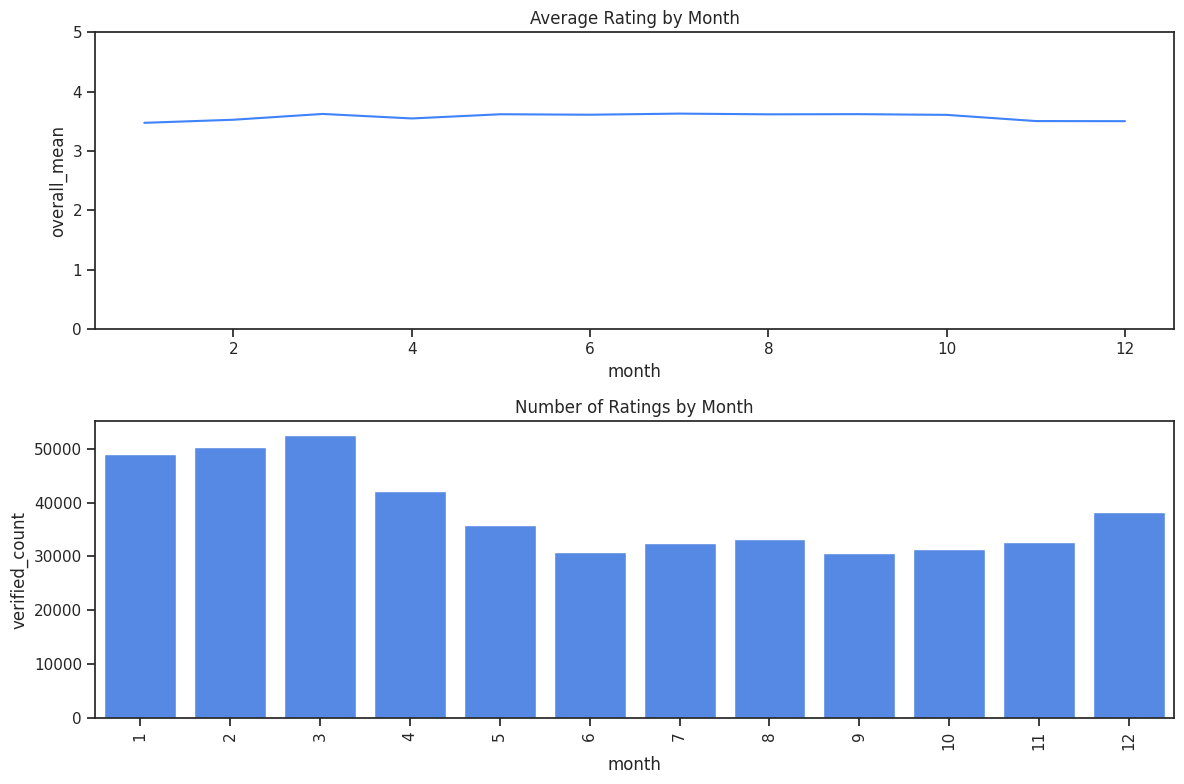

In [ ]:
month_df = aggregate_dataframe_by_column(df=df_software,
                              groupby_column='month',
                              aggregations={'verified': 'count', 'overall': 'mean'})

plot_rating_over_time(df=month_df,
                      time_column="month",
                      avg_rating_col="overall_mean",
                      count_col="verified_count",
                      color="#3e82fc")

In [ ]:
df_products = df_software.groupby('asin').agg(count=('asin', 'size'), overall_mean=('overall', 'mean')).reset_index()
df_products = df_products.merge(df_meta, on='asin')
df_products.head()

,asin,count,overall_mean,category,tech1,description,fit,title,also_buy,tech2,...,feature,rank,also_view,main_cat,similar_item,date,price,imageURL,imageURLHighRes,details
0,0030672120,1,4.0,[],,[],,HOLT PHYSICS LESSON PRESENTATION CD-ROM QUICK ...,[],,...,[],"25,550 in Software (",[],Software,,</div>,.a-box-inner{background-color:#fff}#alohaBuyBo...,[],[],NaN
1,0071480935,5,4.4,[],,"[, <b>Latin rhythms that will get your kids si...",,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)...",[],,...,[],"15,792 in Software (",[],Software,,</div>,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,007329506X,1,1.0,[],,[<b>Connect is the only integrated learning sy...,,Connect with LearnSmart Access Card for Microb...,[],,...,[],"16,900 in Software (",[],Software,,</div>,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
3,0073513458,1,3.0,[],,[],,LearnSmart Standalone Access Card for Prescott...,[],,...,[],"12,986 in Software (",[],Software,,</div>,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
4,0073525758,1,5.0,[],,[<i>Anatomy &amp; Physiology Revealed Cat</i> ...,,Anatomy &amp; Physiology Revealed Student Acce...,"[0323394612, 0323227937, 1118527488]",,...,[],"14,861 in Software (",[],Software,,</div>,$4.83,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


The function **plot_popular_product_or_user** is designed to graphically represent the most popular products or users based on the volume of ratings they've received and their corresponding average ratings.

For the products, it creates a bar graph to display the number of ratings each product has received, which gives a sense of popularity or user engagement with the product. Alongside the bar graph, it plots a point graph that overlays the average rating for each product, providing insight into the general sentiment or quality perception of the product by the users.

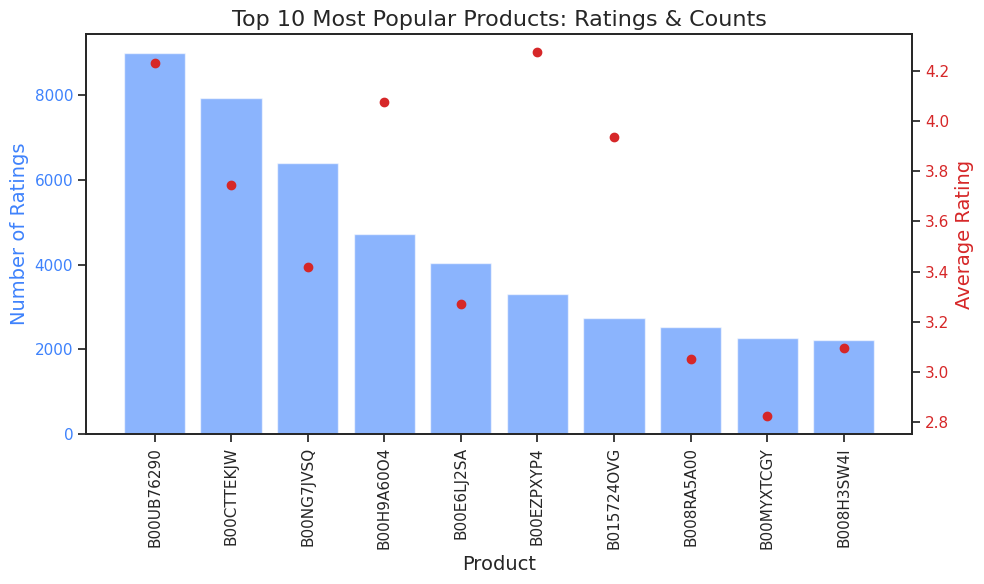

In [ ]:
top_k_products_ids = plot_popular_product_or_user(df=df_products,
                      id_col='asin',
                      count_col='count',
                      rating_col='overall_mean',
                      top_n=10,
                      is_product=1)

The **print_product_descriptions** function is a utility designed to output the descriptions of a list of products, given their identifiers. It takes a pandas DataFrame containing product data, a list of product identifiers (IDs), and the column names corresponding to the product IDs and their descriptions.

In [ ]:
print_product_descriptions(df = df_products,
                           product_id_list = top_k_products_ids,
                           product_id_col= 'asin',
                           description_col='title')

Product Id: B00UB76290
Description: Kindle for PC [Download]

Product Id: B00CTTEKJW
Description: Amazon Music [PC] [Download]

Product Id: B00NG7JVSQ
Description: TurboTax Deluxe 2014 Fed + State + Fed Efile Tax Software - Win [Download] OLD VERSION

Product Id: B00H9A60O4
Description: Avast Free Antivirus 2015 [Download]

Product Id: B00E6LJ2SA
Description: Quicken Deluxe 2014 [Old Version]

Product Id: B00EZPXYP4
Description: NORTON 360 21.0 EN 1U 3LIC MM

Product Id: B015724OVG
Description: Norton Security Deluxe &ndash; 5 Devices &ndash; 1 Year Subscription - Instant Download - 2019 Ready

Product Id: B008RA5A00
Description: Quicken Deluxe 2013

Product Id: B00MYXTCGY
Description: TurboTax Deluxe 2014 Fed + State + Fed Efile Tax Software [Old Version]

Product Id: B008H3SW4I
Description: Microsoft Windows 8 Pro - Upgrade [Old Version]



In [ ]:
df_users = df_software.groupby('reviewerID').agg(count=('reviewerID', 'size'), overall_mean=('overall', 'mean')).reset_index()
df_users.head()

,reviewerID,count,overall_mean
0,A00577669P2XCLU956L8,1,5.0
1,A00621707WIM8QF2CT5O,1,5.0
2,A0065811S4ANKB4TYHII,1,5.0
3,A0086201G57OY58MG97W,2,4.0
4,A0101607BMUAQ65AR9LL,1,5.0


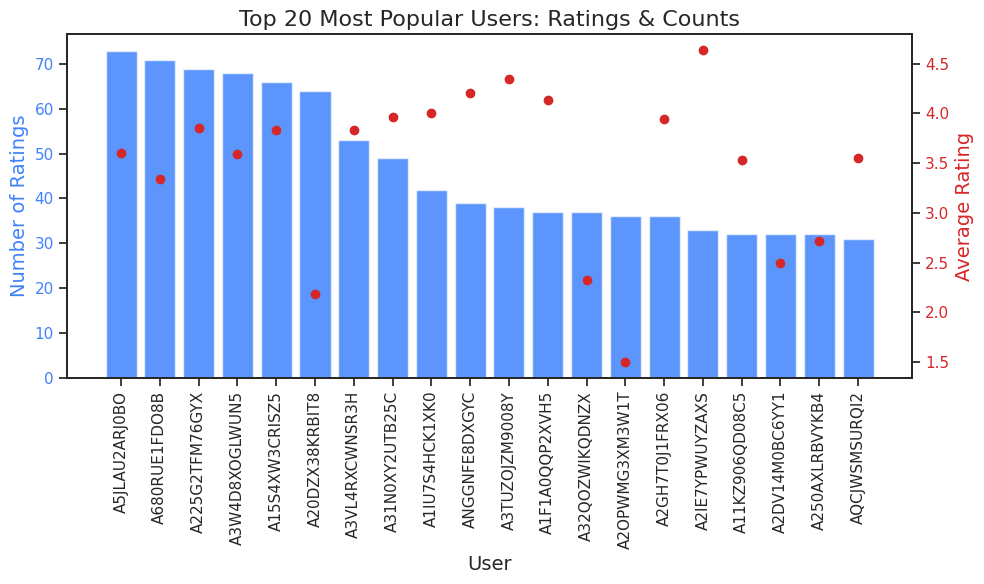

In [ ]:
top_k_users = plot_popular_product_or_user(df=df_users,
                      id_col='reviewerID',
                      count_col='count',
                      rating_col='overall_mean',
                      top_n=20,
                      is_product=0)

### Experimentation

The **filter_dataframe** function is used to refine the dataset by enforcing minimum activity thresholds for both users and products. Specifically, it retains only those users who have written a number of reviews equal to or exceeding the specified user_threshold, and products that have received at least as many ratings as the product_threshold. This is done to ensure the quality of the data by focusing on users who are active and products that have sufficient feedback, which are more reliable for generating recommendations.

In [ ]:
df = df_software[['reviewerID', 'asin', 'overall']]

# Keep only users who have written 3 or more reviews and products that have at least 1 rating.
df_processed = filter_dataframe(df=df,
                                user_col="reviewerID",
                                prod_col="asin",
                                rating_col='overall',
                                product_threshold=1,
                                user_threshold=3)

df_processed.head()

,reviewerID,asin,overall
21,A38NELQT98S4H8,0321719816,4
22,A3QJU4FEN8PQSZ,0321719816,4
23,ACJT8MUC0LRF0,0321719816,5
24,A2RQ0AT4XZUIXL,0321719816,5
25,AYUF7YETYOLNX,0321719816,5


In [ ]:
df_processed.count()

reviewerID    62756
asin          62756
overall       62756
dtype: int64

#### Singular Value Decomposition (SVD)

The `train_svd` function is a comprehensive approach to developing a recommendation system based on matrix factorization. Here's an outline of the steps performed by the function:

1. **Sparsity Calculation**: It begins by assessing the sparsity of our dataset. Sparsity is indicative of the volume of missing information in the user-item interactions.

2. **Initial Model Training**: An initial SVD model is trained with a predefined number of singular values. This model sets a baseline for our expectations and understanding of the data before fine-tuning the model.

3. **Model Evaluation**: The initial model's accuracy is quantified using the RMSE metric on a hold-out test set. The RMSE gives us an indication of the average error in the model's predictions.

4. **Hyperparameter Tuning**: To enhance the model's performance, we perform a grid search over a defined parameter space to find the most effective model settings.

5. **Final Model Training**: After determining the best combination of hyperparameters, the SVD model is retrained on the complete dataset to fully leverage the available information.

### Results of `train_svd`

- **Dataset Sparsity**: The dataset was found to be extremely sparse with a sparsity level of 0.9995, highlighting the challenges of making predictions with limited user-item interactions.

- **Baseline Model Performance**: The initial model, with 5 singular values, achieved an RMSE of 1.3242, setting a benchmark for improvement through hyperparameter optimization.

- **Hyperparameter Optimization**: The grid search evaluated various hyperparameter configurations across multiple folds. The best parameters were found to be: `n_factors` of 50, `n_epochs` of 30, `lr_all` of 0.01, and `reg_all` of 0.1.

- **Optimized Model Performance**: The optimization process yielded a best RMSE of 1.2658, which is a significant improvement over the initial model's performance.


In [ ]:
initial_svd_model, svd_predictions, best_svd_model = train_svd(df= df_processed,
                                                    k_singular_values=5,
                                                    param_grid = {
                                                          'n_factors': [50, 100, 150, 200],
                                                          'n_epochs': [20, 30],
                                                          'lr_all': [0.005, 0.01],
                                                          'reg_all': [0.02, 0.1]
                                                        })

Starting the SVD process...
Dataset Sparsity: The dataset consists of 14739 users and 9458 items, resulting in a sparsity of 0.9995.
Preparing the dataset for model training and evaluation...
Splitting the dataset into training and testing sets...
Training the initial SVD model with n_factors set to 5...
Evaluating the initial model's performance on the test set...
RMSE: 1.3242
Initial Model RMSE: 1.3242
Initiating hyperparameter tuning with GridSearchCV...
Cross-Validation Results:
Fold 1: Mean RMSE = 1.3309334438331755, Mean MAE = 1.094277674063373
Fold 2: Mean RMSE = 1.3328702647665382, Mean MAE = 1.1029146612605838
Fold 3: Mean RMSE = 1.2866811888464278, Mean MAE = 1.031998509069047
Fold 4: Mean RMSE = 1.284607339453281, Mean MAE = 1.043050764065593
Fold 5: Mean RMSE = 1.3027431838786923, Mean MAE = 1.0583820682372618
Fold 6: Mean RMSE = 1.3034396884487547, Mean MAE = 1.0683800484243398
Fold 7: Mean RMSE = 1.276103225592035, Mean MAE = 1.0089822081723485
Fold 8: Mean RMSE = 1.26577

In [ ]:
# Define file paths
initial_svd_model_path = '/content/drive/MyDrive/Recommender_Systems/Models/initial_svd_model.pkl'
svd_predictions_path = '/content/drive/MyDrive/Recommender_Systems/svd_predictions.pkl'
best_svd_model_path = '/content/drive/MyDrive/Recommender_Systems/Models/best_svd_model.pkl'

# Save the initial SVD model
save_to_file(initial_svd_model, initial_svd_model_path)

# Save the SVD predictions list
save_to_file(svd_predictions, svd_predictions_path)

# Save the best SVD model
save_to_file(best_svd_model, best_svd_model_path)

If you want to load the already trained model and use it instead of training the SVD algorithm again, you can uncomment and run the below cell of code.

In [ ]:
# Load the traiend model

# # Define file paths
# initial_svd_model_path = '/content/drive/MyDrive/Recommender_Systems/Models/initial_svd_model.pkl'
# svd_predictions_path = '/content/drive/MyDrive/Recommender_Systems/svd_predictions.pkl'
# best_svd_model_path = '/content/drive/MyDrive/Recommender_Systems/Models/best_svd_model.pkl'

# # Load the initial SVD model
# initial_svd_model = load_from_file(initial_svd_model_path)

# # Load the SVD predictions list
# svd_predictions = load_from_file(svd_predictions_path)

# # Load the best SVD model
# best_svd_model = load_from_file(best_svd_model_path)

##### Personalized Product Recommendations

In [ ]:
df_processed.head(2)

,reviewerID,asin,overall
21,A38NELQT98S4H8,0321719816,4
22,A3QJU4FEN8PQSZ,0321719816,4



The function `recommend_svd` is employed to generate a tailored list of product recommendations for a specific user. This is achieved through the following steps:

1. **User Specification**: The function accepts a unique user identifier (`uid`) to determine the recipient of the recommendations.

2. **Review Data Handling**: It takes the DataFrame `df` containing user reviews and utilizes the `split_dataframe` function to create a ratings matrix from a subset of the data.

3. **Exclusion of Rated Items**: The function compiles a list of items the user has already rated to ensure recommendations are novel.

4. **Prediction of Ratings**: Utilizing a pre-tuned SVD model (`svdtuned`), the function estimates the user's ratings for all unrated products.

5. **Recommendation Assembly**: It sorts these predictions to identify the top-rated products and selects a specified number (`rec_num`) of the highest-rated recommendations.

6. **Metadata Integration**: Product metadata from `df_meta` is then matched with the recommended products to provide context alongside the predicted ratings.

7. **Recommendation Prioritization**: The final DataFrame of recommendations (`rec_df`) is sorted by the predicted ratings to highlight the most relevant products for the user.

8. **Output**: The function returns `rec_df`, a curated list of recommended products, including their titles and predicted ratings, ready for presentation to the user.

###### Example Recommendation of User: A38NELQT98S4H8

In [ ]:
recc_user_1 = recommend_svd(uid="A38NELQT98S4H8", df=df_processed, rec_num=5, svdtuned=best_svd_model, df_meta=df_meta)
recc_user_1

,asin,title,predicted_rating
16884,B001ENOVP2,World of Goo,4.958557
2142,B00004YUHO,PhotoImpact 6.0,4.823107
15518,B000WJ67UQ,Garmin City Navigator Europe NT - Benelux/France,4.809826
13223,B000EORV8Q,Irocks Red USB 2.0 Illuminated 4PORT Hub,4.786696
18013,B002U0L16A,Typing Instructor For Kids Platinum MAC,4.783709


###### Example Recommendation of User: A3QJU4FEN8PQSZ

In [ ]:
recc_user_2 = recommend_svd(uid="A3QJU4FEN8PQSZ", df=df_processed, rec_num=5, svdtuned=best_svd_model,df_meta=df_meta)
recc_user_2

,asin,title,predicted_rating
24140,B00N20ZMOY,Fences [Download],4.406142
16884,B001ENOVP2,World of Goo,4.395780
15518,B000WJ67UQ,Garmin City Navigator Europe NT - Benelux/France,4.338013
2142,B00004YUHO,PhotoImpact 6.0,4.324729
13223,B000EORV8Q,Irocks Red USB 2.0 Illuminated 4PORT Hub,4.305348


##### Model Validation

We use the `validate_svd` function to measure how well our SVD model predicts ratings. It's a simple process:

- **Identify the user**: We input a user ID (`uid`).
- **Split the data**: The dataset `df` is divided into training and testing sets.
- **Make predictions**: The SVD model (`svdtuned`) predicts ratings for items the user hasn't rated yet.
- **Calculate RMSE**: We determine the accuracy of these predictions using the RMSE metric.
- **Show results**: The function outputs a DataFrame with actual vs. predicted ratings, alongside product titles from `df_meta`.

###### Example Validation of User: A38NELQT98S4H8

In [ ]:
rmse_score_user1, recommendations_df_user1 = validate_svd('A38NELQT98S4H8', df_processed, best_svd_model, df_meta=df_meta)
print("Root Mean Squared Error (RMSE):", rmse_score_user1)
print("Recommended Products with Actual and Predicted Ratings:")
recommendations_df_user1

Root Mean Squared Error (RMSE): 0.5882743124314258
Recommended Products with Actual and Predicted Ratings:


,asin,actual_rating,predicted_rating,title
0,B00DT04I9W,5,4.47,Corel Painter X3 (Old Version)
1,B00F2BA8U4,5,4.13,Cyberlink PhotoDirector 5 Ultra
2,B000XHE0Q0,4,3.98,Microsoft Office 2008 for Mac Special Media Ed...


###### Example Validation of User: A3QJU4FEN8PQSZ

In [ ]:
rmse_score_user2, recommendations_df_user2 = validate_svd('A3QJU4FEN8PQSZ', df_processed, best_svd_model,df_meta=df_meta)
print("Root Mean Squared Error (RMSE):", rmse_score_user2)
print("Recommended Products with Actual and Predicted Ratings:")
recommendations_df_user2

Root Mean Squared Error (RMSE): 0.38958311051687033
Recommended Products with Actual and Predicted Ratings:


,asin,actual_rating,predicted_rating,title
0,0321719824,4,3.73,Learn Adobe Flash Professional CS5 by Video: C...
1,B009716H00,3,3.61,Cyberlink PowerDirector 11 Ultimate Suite
3,B00MYXTCNC,3,3.39,TurboTax Premier 2014 Fed + State + Fed Efile ...
2,B0013OAHTG,3,3.10,Corel Ulead VideoStudio 11.5 Plus [OLD VERSION]


#### K-Nearest Neighbors (KNN)

We've developed a function, `train_knn`, to build and refine a K-Nearest Neighbors (KNN) model for our recommendation system. Here's the rundown:

### What It Does:
- **Data Prep**: Converts our reviews dataset into a format suitable for model training.
- **Initial Training**: Kicks off with a basic KNN model to set a performance baseline.
- **Hyperparameter Tuning**: Uses cross-validation to find the best model settings.
- **Unseen Predictions**: Evaluates how well the model predicts ratings for items not yet rated by the user.

### Steps Involved:
1. **Prepare the Dataset**: We format the data and define similarity options.
2. **Split the Data**: Divides our dataset into training and testing portions.
3. **Train the Model**: We start with default parameters to get an initial sense of performance.
4. **Tune the Model**: Optimizes the model by exploring different configurations.
5. **Finalize the Model**: Retrains the model using the best parameters found.

### Key Outputs:
- `initial_knn`: The KNN model before tuning.
- `test_predictions`: Predictions made by the initial model on the test set.
- `best_knn`: The optimized model after tuning.
- `anti_test_predictions`: Predictions made on data the model hasn't seen before.

### Results Summary:
- **Initial RMSE**: We began with an RMSE of 1.2449, indicating the average error in the model's predictions.
- **Tuning Insights**: After fine-tuning, the best RMSE slightly improved, signaling a better fit.
- **Optimal Settings**: The best performance was achieved with `k=10` and Pearson similarity, focusing on user-based similarities.



In [ ]:
# We keep all the users which have at least 5 ratings
df_knn = df_processed.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False).reset_index()
df_rating_knn = df_knn[df_knn['overall'] > 4].reviewerID
df_processed_knn =  df_processed[df_processed['reviewerID'].isin(df_rating_knn)]
df_processed_knn.count()

reviewerID    26352
asin          26352
overall       26352
dtype: int64

In [ ]:
initial_knn_model, knn_predictions, best_knn_model, anti_test_predictions = train_knn(df= df_processed_knn,
                                                                                      param_grid = {
                                                                                              'k': [10, 20, 40, 100],
                                                                                              'sim_options': {
                                                                                                  'name': ['msd', 'cosine', 'pearson'],
                                                                                                  'min_support': [1, 5, 10],
                                                                                                  'user_based': [True]
                                                                                              }
                                                                                          })

Starting the KNN process...
Preparing the dataset for model training and evaluation...
Splitting the dataset into training and testing sets...
Training the initial KNN model with default parameters...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating the initial model's performance on the test set...
RMSE: 1.2449
Initial Model RMSE: 1.2449
Initiating hyperparameter tuning with GridSearchCV...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing simil

In [ ]:
# Use subset in order to free memory
anti_test_predictions = anti_test_predictions[:10000]

In [ ]:
# Save Models

#  Define file paths
initial_knn_model_path = '/content/drive/MyDrive/Recommender_Systems/Models/initial_knn_model.pkl'
knn_predictions_path = '/content/drive/MyDrive/Recommender_Systems/knn_predictions.pkl'
best_knn_model_path = '/content/drive/MyDrive/Recommender_Systems/Models/best_knn_model.pkl'
anti_test_predictions_path = '/content/drive/MyDrive/Recommender_Systems/Models/anti_test_predictions.pkl'

# Save the initial KNN model
save_to_file(initial_knn_model, initial_knn_model_path)

# Save the KNN predictions list
save_to_file(knn_predictions, best_knn_model_path)

# Save the best KNN model
save_to_file(best_knn_model, best_knn_model_path)

# # Save the anti-test predictions
save_to_file(anti_test_predictions, anti_test_predictions_path)

Object saved to /content/drive/MyDrive/Recommender_Systems/Models/initial_knn_model.pkl
Object saved to /content/drive/MyDrive/Recommender_Systems/Models/best_knnmodel.pkl
Object saved to /content/drive/MyDrive/Recommender_Systems/Models/best_knnmodel.pkl
Object saved to /content/drive/MyDrive/Recommender_Systems/Models/anti_test_predictions.pkl


If you want to load the already trained model and use it instead of training the KNN model again, you can uncomment and run the below cell of code.

In [ ]:
# # Load trained models

# #  Define file paths
# initial_knn_model_path = '/content/drive/MyDrive/Recommender_Systems/Models/initial_knn_model.pkl'
# knn_predictions_path = '/content/drive/MyDrive/Recommender_Systems/knn_predictions.pkl'
# best_knn_model_path = '/content/drive/MyDrive/Recommender_Systems/Models/best_knnmodel.pkl'
# anti_test_predictions_path = '/content/drive/MyDrive/Recommender_Systems/Models/anti_test_predictions.pkl'

# # Load the initial SVD model
# initial_knn_model = load_from_file(initial_knn_model_path)

# # Load the SVD predictions list
# knn_predictions = load_from_file(knn_predictions_path)

# # Load the best SVD model
# best_knn_model = load_from_file(best_knn_model_path)

# # Load the best SVD model
# anti_test_predictions = load_from_file(anti_test_predictions_path)

##### Personalized Product Recommendations

The `recommend_knn` function leverages a K-Nearest Neighbors (KNN) model to provide personalized recommendations to users. Here's how the magic happens:

1. Understanding the User: First, we dive into the user's history by examining their past ratings. This step ensures we understand their preferences and avoid recommending items they've already explored.

2.  Leveraging Predictions: We then sift through a list of predicted ratings generated by the KNN model.

3. Curating Recommendations: The core of this process is selecting items with the highest predicted ratings. However, it's not just about the ratings; we're looking for items the user hasn't rated yet, unveiling a curated list of new experiences tailored to their taste.

4. Final Touches: The culmination of this process is a carefully sorted list of the top recommendations, prioritized by the strength of their predicted appeal to the user.

In [ ]:
df_processed_knn.head(2)

,reviewerID,asin,overall
21,A38NELQT98S4H8,0321719816,4
22,A3QJU4FEN8PQSZ,0321719816,4


###### Example Recommendation of User: A38NELQT98S4H8

In [ ]:
user_1_ratings = df_processed_knn[df_processed_knn.reviewerID == 'A38NELQT98S4H8']
user_1_ratings = user_1_ratings.merge(df_meta, on='asin')
user_1_ratings = user_1_ratings[['reviewerID','asin', 'title', 'overall', 'description', 'rank', 'also_buy', 'also_view']]
user_1_ratings.head()

,reviewerID,asin,title,overall,description,rank,also_buy,also_view
0,A38NELQT98S4H8,0321719816,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,4,[This complete training program from Adobe Pre...,"9,956 in Software (",[],[]
1,A38NELQT98S4H8,B000XHE0Q0,Microsoft Office 2008 for Mac Special Media Ed...,4,[For media-savvy Mac users to achieve more & s...,"4,265 in Software (",[],[]
2,A38NELQT98S4H8,B000XHE0Q0,Microsoft Office 2008 for Mac Special Media Ed...,4,[For media-savvy Mac users to achieve more & s...,"4,265 in Software (",[],[]
3,A38NELQT98S4H8,B003HCA7GA,AutoCAD Freestyle [Old Version],1,[AutoCAD Freestyle is the simple design tool f...,"19,666 in Software (",[],[]
4,A38NELQT98S4H8,B00DT04I9W,Corel Painter X3 (Old Version),5,[Get inspired with Corel Painter X3. The lates...,"6,954 in Software (",[],"[B07DHCL9C6, B0799C43LY, B01HWQ5UFO]"


In [ ]:
recc_user_1_knn = recommend_knn(uid="A38NELQT98S4H8", ratings_df= user_1_ratings, pred_df=pd.DataFrame(anti_test_predictions), df_meta=df_meta, rec_num=5)
recc_user_1_knn

,iid,est,title
0,0321700945,3.888889,Learn Adobe Photoshop Lightroom 3 by Video
1,B000AYKTAM,3.888889,Microsoft Digital Image Suite 2006 Plus Pinnac...
2,B000B676FA,3.888889,Jump &amp; Ride: Riding Academy
3,B000B6JAQI,3.888889,Trend Micro Anti-Spyware 3.0 [Old Version]
4,B000B6N2LC,3.888889,Calendar Creator Version 12 Essentials


###### Example Recommendation of User: A3QJU4FEN8PQSZ

In [ ]:
user_2_ratings = df_processed_knn[df_processed_knn.reviewerID == 'A3QJU4FEN8PQSZ']
user_2_ratings = user_2_ratings.merge(df_meta, on='asin')
user_2_ratings = user_2_ratings[['reviewerID','asin', 'title', 'overall', 'description', 'rank', 'also_buy', 'also_view']]
user_2_ratings.head()

,reviewerID,asin,title,overall,description,rank,also_buy,also_view
0,A3QJU4FEN8PQSZ,0321719816,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,4,[This complete training program from Adobe Pre...,"9,956 in Software (",[],[]
1,A3QJU4FEN8PQSZ,0321719824,Learn Adobe Flash Professional CS5 by Video: C...,4,[This complete training program from Adobe Pre...,"11,954 in Software (",[],[]
2,A3QJU4FEN8PQSZ,B0013OAHTG,Corel Ulead VideoStudio 11.5 Plus [OLD VERSION],3,[Ulead VideoStudio 11 Plus is video editing an...,"12,742 in Software (",[],[B079DF3BT3]
3,A3QJU4FEN8PQSZ,B0013OAHTG,Corel Ulead VideoStudio 11.5 Plus [OLD VERSION],3,[Ulead VideoStudio 11 Plus is video editing an...,"12,742 in Software (",[],[B079DF3BT3]
4,A3QJU4FEN8PQSZ,B001AFCWBO,"Rosetta Stone Version 3: Chinese Level 1, 2 &a...",3,"[As children, we gradually learned our first l...","16,774 in Software (",[],[]


In [ ]:
recc_user_2_knn = recommend_knn(uid="A3QJU4FEN8PQSZ", ratings_df= user_2_ratings, pred_df=pd.DataFrame(anti_test_predictions), df_meta=df_meta, rec_num=5)
recc_user_2_knn

,iid,est,title
0,0321700945,3.5,Learn Adobe Photoshop Lightroom 3 by Video
1,B01617VTBO,3.5,H&amp;R Block 2015 Deluxe Tax Software + Refun...
2,B01617VPUY,3.5,TurboTax Deluxe 2015 Federal + State Taxes + F...
3,B01617VQJ4,3.5,Intuit TurboTax Premier 2015 Federal + State T...
4,B01723PG10,3.5,ESET SMART Security 3U 1Y 2016


##### Model Validation


The `validate_knn` function plays a pivotal role in assessing the accuracy of our KNN model's recommendations. By comparing predicted ratings against actual user ratings, it provides a quantitative measure of the model's performance. Here's a breakdown of how this function enriches our recommendation system's reliability:

### Conceptual Overview
- **Goal**: To ensure that the recommendations made by our KNN model align closely with the user's genuine preferences.
- **Method**: It calculates the Root Mean Squared Error (RMSE).

### Operational Flow
1. **Focus on the User**: The function starts by isolating the ratings provided by a specific user, forming the basis of our validation.
2. **Prediction vs. Reality**: For each item the user has rated, we compare their actual rating against the rating predicted by our KNN model.
3. **Accuracy Measurement**: By aggregating these comparisons, we calculate the RMSE, providing a single, comprehensive metric that reflects the model's prediction accuracy.


###### Example Validation of User: A38NELQT98S4H8

In [ ]:
rmse_score_user1_knn = validate_knn(uid='A38NELQT98S4H8', ratings_df=user_1_ratings, pred_df=pd.DataFrame(anti_test_predictions), model=best_knn_model)
print("Root Mean Squared Error (RMSE):", rmse_score_user1_knn)

[4, 4, 1, 5, 5, 4, 4, 4] [4.0, 4.0, 1, 5, 5, 4.0, 4.0, 4.0]
Root Mean Squared Error (RMSE): 0.0


###### Example Validation of User: A3QJU4FEN8PQSZ

In [ ]:
rmse_score_user2_knn = validate_knn(uid='A3QJU4FEN8PQSZ', ratings_df=user_2_ratings, pred_df=pd.DataFrame(anti_test_predictions), model=best_knn_model)
print("Root Mean Squared Error (RMSE):", rmse_score_user2_knn)

[4, 4, 3, 3, 4, 5, 5, 3, 3, 4, 1] [4.0, 4.0, 3.0, 3.0, 4.0, 5, 5, 3.0, 3.0, 4.0, 1]
Root Mean Squared Error (RMSE): 0.0


#### Item-Based Approach

The **recommend_item_based** function is designed to deliver personalized item recommendations to users within a platform, utilizing an approach that leverages Locality Sensitive Hashing (LSH) indexing for efficiency and accuracy. Below is an explanation of the function's mechanics and the rationale behind using LSH indexing in this context.

1. Neighbor Retrieval: The function begins by identifying neighbors for the given user ID through the LSH index. These neighbors represent users with similar tastes or items that share similarities with those the user has interacted with.
2. Vote Accumulation: It then calculates 'votes' for each item based on the neighbors' interactions. Items rated positively by similar users receive more votes, while those rated negatively receive fewer votes. This voting mechanism allows the system to gauge the overall appeal of items within the user's similarity network.
3. Recommendation Generation: The items are then ranked based on their accumulated votes, and the top rec_num items are selected as recommendations.
4. Exclusion of Already Rated Items: Optionally, the function can exclude items the user has already rated from the recommendation list.
5. Output Preparation: Finally, the function prepares and returns two DataFrames: one for the recommended items and another for items already rated by the user, facilitating easy review and analysis of the recommendations.

**Why Use LSH Indexing?**

 We build the indexer because in the recommendation item-based function it allows us to quickly find items that are similar to those a user has positively rated in the past. By identifying these items, we can recommend products that, although not directly interacted with by the user, share characteristics with items they liked.

In [ ]:
df_prods = df_processed.groupby(by='asin')['overall'].count().sort_values(ascending=False).reset_index()
df_prods.head()

,asin,overall
0,B0000AZJY6,568
1,B00EZPXYP4,428
2,B00CTTEKJW,398
3,B00UB76290,371
4,B00NG7JVSQ,339


In [ ]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62756 entries, 21 to 459433
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewerID  62756 non-null  object
 1   asin        62756 non-null  object
 2   overall     62756 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


In [ ]:
df_prods.describe()

,overall
count,9458.000000
mean,6.635229
std,20.910125
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,568.000000


We can observe that the 50 percentile of rated products is 2, so we can use it as filter in order to keep the most important products

In [ ]:
rat = df_prods[df_prods['overall'] >= 2].asin
ratings_df =  df_processed[df_processed['asin'].isin(rat)]
ratings_df.shape

(58216, 3)

In [ ]:
df_prods = ratings_df.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False).reset_index()
df_prods.describe()

,overall
count,14649.000000
mean,3.974060
std,2.729676
min,1.000000
25%,3.000000
50%,3.000000
75%,4.000000
max,67.000000


We do the same for users too. We can observe that the values here lower than the ones related to products.

In [ ]:
rat = ratings_df[ratings_df['overall'] > 3].reviewerID
ratings_df =  ratings_df[ratings_df['reviewerID'].isin(rat)]
ratings_df.head()

,reviewerID,asin,overall
21,A38NELQT98S4H8,0321719816,4
22,A3QJU4FEN8PQSZ,0321719816,4
23,ACJT8MUC0LRF0,0321719816,5
24,A2RQ0AT4XZUIXL,0321719816,5
25,AYUF7YETYOLNX,0321719816,5


In [ ]:
indexer = LSHSimilarity(ratings_df[['reviewerID', 'asin', 'overall']], 'reviewerID')

indexer.index(jaccard_threshold=0.1)

Index built with 200 permutations


Entities processed:   6%|▌         | 764/12597 [00:00<00:05, 2244.80it/s]

500 out of 12597 entities indexed.


Entities processed:  10%|█         | 1265/12597 [00:00<00:04, 2369.21it/s]

1000 out of 12597 entities indexed.


Entities processed:  14%|█▍        | 1797/12597 [00:00<00:04, 2540.91it/s]

1500 out of 12597 entities indexed.
2000 out of 12597 entities indexed.


Entities processed:  22%|██▏       | 2815/12597 [00:01<00:04, 2272.12it/s]

2500 out of 12597 entities indexed.


Entities processed:  26%|██▌       | 3292/12597 [00:01<00:04, 2232.29it/s]

3000 out of 12597 entities indexed.
3500 out of 12597 entities indexed.


Entities processed:  34%|███▍      | 4316/12597 [00:01<00:03, 2258.49it/s]

4000 out of 12597 entities indexed.


Entities processed:  38%|███▊      | 4769/12597 [00:02<00:03, 2198.80it/s]

4500 out of 12597 entities indexed.


Entities processed:  43%|████▎     | 5477/12597 [00:02<00:03, 2311.06it/s]

5000 out of 12597 entities indexed.
5500 out of 12597 entities indexed.


Entities processed:  50%|█████     | 6360/12597 [00:03<00:04, 1470.00it/s]

6000 out of 12597 entities indexed.


Entities processed:  54%|█████▍    | 6791/12597 [00:03<00:03, 1750.26it/s]

6500 out of 12597 entities indexed.
7000 out of 12597 entities indexed.


Entities processed:  61%|██████▏   | 7746/12597 [00:03<00:02, 2088.49it/s]

7500 out of 12597 entities indexed.


Entities processed:  67%|██████▋   | 8387/12597 [00:04<00:02, 2003.64it/s]

8000 out of 12597 entities indexed.


Entities processed:  70%|███████   | 8823/12597 [00:04<00:01, 2065.90it/s]

8500 out of 12597 entities indexed.


Entities processed:  74%|███████▍  | 9325/12597 [00:04<00:01, 2240.21it/s]

9000 out of 12597 entities indexed.


Entities processed:  78%|███████▊  | 9772/12597 [00:04<00:01, 2164.94it/s]

9500 out of 12597 entities indexed.


Entities processed:  81%|████████▏ | 10239/12597 [00:05<00:01, 2248.28it/s]

10000 out of 12597 entities indexed.


Entities processed:  87%|████████▋ | 10918/12597 [00:05<00:00, 2171.50it/s]

10500 out of 12597 entities indexed.


Entities processed:  90%|█████████ | 11393/12597 [00:05<00:00, 2258.47it/s]

11000 out of 12597 entities indexed.
11500 out of 12597 entities indexed.


Entities processed:  98%|█████████▊| 12407/12597 [00:05<00:00, 2254.10it/s]

12000 out of 12597 entities indexed.


Entities processed: 100%|██████████| 12597/12597 [00:06<00:00, 2071.36it/s]

12500 out of 12597 entities indexed.
reviewerID-based index created


##### Personalized Product Recommendations

###### Example Recommendation of User: A38NELQT98S4H8

In [ ]:
user_1_ratings = df_processed[df_processed.reviewerID == 'A38NELQT98S4H8']
user_1_ratings = user_1_ratings.merge(df_meta, on='asin')
user_1_ratings = user_1_ratings[['reviewerID','asin', 'title', 'overall', 'description', 'rank', 'also_buy', 'also_view']]
user_1_ratings.head(3)

,reviewerID,asin,title,overall,description,rank,also_buy,also_view
0,A38NELQT98S4H8,0321719816,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,4,[This complete training program from Adobe Pre...,"9,956 in Software (",[],[]
1,A38NELQT98S4H8,B000XHE0Q0,Microsoft Office 2008 for Mac Special Media Ed...,4,[For media-savvy Mac users to achieve more & s...,"4,265 in Software (",[],[]
2,A38NELQT98S4H8,B000XHE0Q0,Microsoft Office 2008 for Mac Special Media Ed...,4,[For media-savvy Mac users to achieve more & s...,"4,265 in Software (",[],[]


In [ ]:
df_rec, df_alredy_rated = recommend_item_based(indexer, user_id='A38NELQT98S4H8', rec_num=5)
df_rec

,asin,title,score
0,B00EZ6O4WA,McAfee AntiVirus Plus 2014 (3PCs),0.307692
1,B01AC3ZA7C,Corel VideoStudio Pro X9 (Old Version),0.307692
2,B00BFNCFZ4,VideoStudio Pro X6 [OLD VERSION],0.307692
3,B00LYYMXF6,Corel Painter 2015 (Old Version),0.307692
4,B00FB5R4L2,Nero 2014 Platinum [Old Version],0.210526


###### Example Recommendation of User: A3QJU4FEN8PQSZ

In [ ]:
user_2_ratings = df_processed[df_processed.reviewerID == 'A3QJU4FEN8PQSZ']
user_2_ratings = user_2_ratings.merge(df_meta, on='asin')
user_2_ratings = user_2_ratings[['reviewerID','asin', 'title', 'overall', 'description', 'rank', 'also_buy', 'also_view']]
user_2_ratings.head(3)

,reviewerID,asin,title,overall,description,rank,also_buy,also_view
0,A3QJU4FEN8PQSZ,0321719816,Learn Adobe Dreamweaver CS5 by Video: Core Tra...,4,[This complete training program from Adobe Pre...,"9,956 in Software (",[],[]
1,A3QJU4FEN8PQSZ,0321719824,Learn Adobe Flash Professional CS5 by Video: C...,4,[This complete training program from Adobe Pre...,"11,954 in Software (",[],[]
2,A3QJU4FEN8PQSZ,B0013OAHTG,Corel Ulead VideoStudio 11.5 Plus [OLD VERSION],3,[Ulead VideoStudio 11 Plus is video editing an...,"12,742 in Software (",[],[B079DF3BT3]


In [ ]:
df_rec, df_alredy_rated = recommend_item_based(indexer, user_id='A3QJU4FEN8PQSZ', rec_num=5)
df_rec

,asin,title,score
0,B005LXIJ7M,Poser 9,0.496241
1,B002ABMVD6,Anime Studio Debut 6 [OLD VERSION],0.285714
2,B01FFVDY9M,Corel AfterShot Pro 3 Photo Editing Software f...,0.285714
3,B001ENOVP2,World of Goo,0.285714
4,B004E9SKFA,Microsoft Office Professional 2010 (2PC/1 Use...,0.285714


##### Model Validation

To validate our item-based recommendation system, we devised a systematic approach. First, we gathered data consisting of interactions between users and items. This dataset served as the foundation for our evaluation process.

We then developed a validation function, **validate_item_based_recommendations**, to assess the performance of our recommendation system. This function takes into account the user's past interactions, generates recommendations using our recommendation algorithm, and calculates both the novelty score and the NDCG score.


**Novelty Score**

The novelty score measures the diversity and uniqueness of the recommended items compared to the user's past interactions. By analyzing the novelty score, we gain insights into the system's ability to introduce new and diverse items to users, enhancing their overall experience. The novelty score typically ranges from 0 to 1, with 1 representing the highest level of novelty.

**NDCG Score**
The NDCG score evaluates the quality of the ranking of recommended items. It considers both the relevance of the items and their positions in the recommendation list. A high NDCG score indicates that the recommended items are not only relevant but also effectively prioritized, leading to improved user satisfaction. The NDCG score also ranges from 0 to 1, with 1 indicating a perfect ranking of recommended items.

###### Example Validation of User: A38NELQT98S4H8

In [ ]:
novelty_score, ndcg_score = validate_item_based_recommendations(user_1_ratings.asin.unique(),'A38NELQT98S4H8',indexer)
print(f"Novelty Score: {novelty_score}")
print(f"NDCG Score: {ndcg_score}")

Novelty Score: 0.875
NDCG Score: 0.8616393654599965


###### Example Validation of User: A3QJU4FEN8PQSZ

In [ ]:
novelty_score, ndcg_score = validate_item_based_recommendations(user_2_ratings.asin.unique(),'A3QJU4FEN8PQSZ',indexer)
print(f"Novelty Score: {novelty_score}")
print(f"NDCG Score: {ndcg_score}")

Novelty Score: 0.76
NDCG Score: 0.8005419662712061
